In [1]:
import numpy as np
import matplotlib.pyplot as plt

import scipy

from numba import njit

Most of this code is borrowed from class. The original code can be found here: https://www.physics.rutgers.edu/grad/509/Vegas.html

To do this homework, I'm just making small modifications.

In [2]:
class Cumulants:
    def __init__(self):
        self.sum=0.0    # f_0 + f_1 +.... + f_N
        self.sqsum=0.0  # f_0^2 + f_1^2 +....+ f_N^2
        self.avg = 0.0  # I_best when many iterations, otherwise <f> = 1/N\sum_i f_i
        self.err = 0.0  # sigma of I_best when many iterations, otherwise sqrt( <f^2>-<f>^2 )/sqrt(N)
        self.chisq = 0.0
        self.weightsum=0.0 # \sum_i 1/sigma_i^2
        self.avgsum=0.0    # \sum_i <f>_i/sigma_i^2
        self.avg2sum=0.0   # \sum_i <f>_i^2/sigma_i^2

In [3]:
@njit
def RefineGrid__(g, imp):
    # imp[idim,ibin] is the input function \widetilde{f}(g) from which we construct the grid
    (ndim,nbins) = np.shape(imp)
    gnew = np.zeros((ndim,nbins+1))
    for idim in range(ndim):
        avgperbin = sum(imp[idim,:])/nbins
        #**** redefine the size of each bin  ****
        newgrid = np.zeros(nbins)
        cur=0.0
        newcur=0.0
        thisbin = 0.0
        ibin = -1
        # we are trying to determine
        #   Int[ f(g) dg, {g, g_{i-1},g_i}] == I/N_g
        #   where I == avgperbin
        for newbin in range(nbins-1):  # all but the last bin, which is 1.0
            while (thisbin < avgperbin) :
                ibin+=1
                thisbin += imp[idim,ibin] # adding widetilde{f}(g)
                prev = cur               # g^old_{l-1}
                cur = g[idim,ibin]  # g^old_{l}
            # Explanation is in order : 
            #   g^new_l should be somewhere between g^old_l and g^old_{l-1}, because if we add the last point
            #      we exceeded I/Ng value, while withouth the last point, we do not have enough. Hence need to interpolate.
            #   prev    -- g^{old}_{l-1}
            #   cur     -- g^{old}_l
            #   thisbin -- Sm = f_{l-k}+.... +f_{l-2}+f_{l-1}+f_l
            #   we know that  Sm is just a bit more than we need, i.e., I/N_g, hence we need to compute how much more
            #   using linear interpolation :
            #   g^{new} = g_l - (g_l-g_{l-1}) * (f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)/f_l
            #    clearly
            #         if I/N_g == f_{l-k}+....+f_{l-2}+f_{l-1}+f_l
            #            we will get g^{new} = g_l
            #     and if I/N_g == f_{l-k}+....+f_{l-2}+f_{l-1}
            #            we will get g^{new} = g_{l-1}
            #     and if I/N_g  is between the two possibilities, we will get linear interpolation between
            #     g_{l-1} and g_l
            #     
            thisbin -= avgperbin   # thisbin <- (f_{l-k}+....+f_{l-2}+f_{l-1}+f_l - I/N_g)
            dx=thisbin/imp[idim,ibin] # dx is between 0 and 1
            # cur=g_l and prev=g_{l-1} and dx is the fraction of each we need to take for linear interpolation
            newgrid[newbin] = cur + (prev-cur)*dx # linear interpolation between g_l and g_{l-1}

        newgrid[nbins-1]=1.0
        gnew[idim,:nbins]= newgrid
    #g = gnew
    return gnew


class Grid:
    """Contains the grid points g_n(x) with x=[0...1], and g=[0...1]
       for Vegas integration. There are n-dim g_n functions.
       Constraints : g(0)=0 and g(1)=1.
    """
    def __init__(self, ndim, nbins):
        self.g = np.zeros((ndim,nbins+1))  
        # a bit dirty trick: We will later use also g[-1] in interpolation, which should be set to zero, hence
        # we allocate dimension nbins+1, rather than nbinx
        self.ndim=ndim
        self.nbins=nbins
        # At the beginning we set g(x)=x
        # The grid-points are x_0 = 1/N, x_1 = 2/N, ... x_{N-1}=1.0. 
        # Note that g(0)=0, and we skip this point on the mesh.
        for idim in range(ndim):
            self.g[idim,:nbins] = np.arange(1,nbins+1)/float(nbins)
            
    def RefineGrid(self, imp):
        self.g = RefineGrid__(self.g, imp)
        return self.g

In [4]:
def Smoothen(fxbin):
    (ndim,nbins) = np.shape(fxbin)
    final = np.zeros(np.shape(fxbin))
    for idim in range(ndim):
        fxb = np.copy(fxbin[idim,:]) # widetilde{f}(x) copied
        #**** smooth the widetilde{f} value stored for each bin ****
        # f[i] <- (f[i+1]+f[i]+f[i-1])/3.
        fxb[:nbins-1] += fxbin[idim,1:nbins]
        fxb[1:nbins]  += fxbin[idim,:nbins-1]
        fxb[1:nbins-1] *= 1/3.
        fxb[0] *= 1/2.
        fxb[nbins-1] *= 1/2.
        norm = sum(fxb)
        if( norm == 0 ):
            print ('ERROR can not refine the grid with zero grid function')
            return # can not refine the grid if the function is zero.
        fxb *= 1.0/norm         # we normalize the function.
        # Note that normalization is such that the sum is 1.
        # And than we take the square root of abs value just in case the value is negative at a point.
        final[idim,:] = np.sqrt(abs(fxb))
    return final

In [5]:
@njit
def SetFxbin(fxbin,bins,wfun):
    (n,ndim) = bins.shape
    for dim in range(ndim):
        # Here we make a better approximation for the function, which we are integrating.
        for i in range(n):
            fxbin[dim, bins[i,dim] ] += abs(wfun[i]) # just bin the function f. We saved the bin position before.                


def Vegas_step3b(integrant, unit, maxeval, nstart, nincrease, grid, cum):
    ndim, nbins = grid.ndim,grid.nbins  # dimension of the integral, size of the grid for binning in each direction
    unit_dim = unit**ndim   # converts from unit cube integration to generalized cube with unit length
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    print ("""Vegas parameters:
       ndim = """+str(ndim)+"""
       unit = """+str(unit)+"""
       maxeval = """+str(maxeval)+"""
       nstart = """+str(nstart)+"""
       nincrease = """+str(nincrease)+"""
       nbins = """+str(nbins)+"""
       nbaths = """+str(nbatch)+"\n")

    bins = np.zeros((nbatch,ndim),dtype=int) # in which sampled bin does this point fall?
    
    
    all_nsamples = nstart
    for iter in range(1000):         # NEW in step 3
        wgh = np.zeros(nbatch)            # weights for each random point in the batch
        fxbin = np.zeros((ndim,nbins))    # after each iteration we reset the average function being binned
        for nsamples in range(all_nsamples,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
            n = min(nbatch,nsamples)  # How many evaluations in this pass?
            # We are integrating f(g_1(x),g_2(y),g_3(z))*dg_1/dx*dg_2/dy*dg_3/dz dx*dy*dz
            # This is represented as  1/all_nsamples \sum_{x_i,y_i,z_i} f(g_1(x_i),g_2(y_i),g_3(z_i))*dg_1/dx*dg_2/dy*dg_3/dz
            #  where dg_1/dx = diff*NBINS
            xr = np.random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
            pos = xr*nbins                   # (x*N)
            bins = np.array(pos,dtype=int)      # which grid would it fit ? (x*N)
            wgh = np.ones(nbatch)/all_nsamples
            for dim in range(ndim):   
                # We want to evaluate the function f at point g(x), i.e, f(g_1(x),g_2(y),...)
                # Here we transform the points x,y,z -> g_1(x), g_2(y), g_3(z)
                # We hence want to evaluate g(x) ~ g(x[i]), where x is the random number and g is the grid function
                # The discretized g(t) is defined on the grid :
                #       t[-1]=0, t[0]=1/N, t[1]=2/N, t[2]=3/N ... t[N-1]=1.
                # We know that g(0)=0 and g(1)=1, so that g[-1]=0.0 and g[N-1]=1.0
                # To interpolate g at x, we first compute  i=int(x*N) and then we use linear interpolation
                # g(x) = g[i-1] + (g[i]-g[i-1])*(x*N-int(x*N))
                gi = grid.g[dim,bins[:,dim]]            # g[i]
                gm = grid.g[dim,bins[:,dim]-1]          # g[i-1]
                diff = gi - gm                          # g[i]-g[i-1]
                gx = gm + (pos[:,dim]-bins[:,dim])*diff # linear interpolation g(xr)
                xr[:,dim] = gx*unit                     # xr <- g(xr)
                wgh *= diff*nbins                       # wgh = prod_{dim} dg/dx
            
            # Here we evaluate function f on all randomly generated x points above
            fx = integrant(xr)  # n function evaluations required in single call
            neval += n  # We just added so many fuction evaluations
            
            # Now we compute the integral as weighted average, namely, f(g(x))*dg/dx
            wfun = wgh * fx           # weight * function ~ f_i*w_i            
            cum.sum += sum(wfun)      # sum_i f_i*w_i = <fw>
            wfun *= wfun              # carefull : this is like  (f_i * w_i/N)^2 hence  1/N (1/N (f_i*w_i)^2)
            cum.sqsum += sum(wfun)    # sum_i (f_i*w_i)^2 = <fw^2>/all_nsamples
                                      # 
            SetFxbin(fxbin,bins,wfun)
            #for dim in range(ndim):   #new2
            #    # Here we make a better approximation for the function, which we are integrating.
            #    for i in range(n):    #new2
            #        fxbin[dim, bins[i,dim] ] += wfun[i] #new2: just bin the function f. We saved the bin position before.
            
        w0 = np.sqrt(cum.sqsum*all_nsamples)  # w0 = sqrt(<fw^2>)
        w1 = (w0 + cum.sum)*(w0 - cum.sum) # w1 = (w0^2 - <fw>^2) = (<fw^2>-<fw>^2)
        w = (all_nsamples-1)/w1            # w ~ 1/sigma_i^2 = (N-1)/(<fw^2>-<fw>^2)
        # Note that variance of the MC sampling is Var(monte-f) = (<f^2>-<f>^2)/N == 1/sigma_i^2
        cum.weightsum += w          # weightsum ~ \sum_i 1/sigma_i^2
        cum.avgsum += w*cum.sum     # avgsum    ~ \sum_i <fw>_i / sigma_i^2
        cum.avg2sum += w*cum.sum**2  # avg2cum   ~ \sum_i <fw>_i^2/sigma_i^2
        
        cum.avg = cum.avgsum/cum.weightsum     # I_best = (\sum_i <fw>_i/sigma_i^2 )/(\sum_i 1/sigma_i^2)
        cum.err = np.sqrt(1/cum.weightsum)        # err ~ sqrt(best sigma^2) = sqrt(1/(\sum_i 1/sigma_i^2))
     
        # NEW in this step3
        if iter>0:
            cum.chisq = (cum.avg2sum - 2*cum.avgsum*cum.avg + cum.weightsum*cum.avg**2)/iter
    
        print ("Iteration {:3d}: I= {:10.8f} +- {:10.8f}  chisq= {:10.8f} number of evaluations = {:7d} ".format(iter+1, cum.avg*unit_dim, cum.err*unit_dim, cum.chisq, neval))
        imp = Smoothen(fxbin)
        grid.RefineGrid(imp)
        
        cum.sum=0                    # clear the partial sum for the next step
        cum.sqsum=0
        all_nsamples += nincrease    # for the next time, increase the number of steps a bit
        if (neval>=maxeval): break
        
    cum.avg *= unit**ndim
    cum.err *= unit**ndim

In [16]:
@njit
def SetFxbin(fxbin,bins,wfun):
    (n,ndim) = bins.shape
    for dim in range(ndim):
        # Here we make a better approximation for the function, which we are integrating.
        for i in range(n):
            fxbin[dim, bins[i,dim] ] += abs(wfun[i]) # just bin the function f. We saved the bin position before.                


def Vegas_step4(integrant, ab, maxeval, nstart, nincrease, grid, cum):
    ndim, nbins = grid.ndim, grid.nbins  # dimension of the integral, size of the grid for binning in each direction
    #unit_dim = unit**ndim   # converts from unit cube integration to generalized cube with unit length
    #unit_dim = np.prod(ab[:,1]-ab[:,0])
    unit_dim = (ab[1]-ab[0])**ndim
    nbatch=1000             # function will be evaluated in bacthes of 1000 evaluations at one time (for efficiency and storage issues)
    neval=0
    print ("""Vegas parameters:
       ndim = """+str(ndim)+"""
       unit = """+str(unit)+"""
       maxeval = """+str(maxeval)+"""
       nstart = """+str(nstart)+"""
       nincrease = """+str(nincrease)+"""
       nbins = """+str(nbins)+"""
       nbaths = """+str(nbatch)+"\n")

    bins = np.zeros((nbatch,ndim),dtype=int) # in which sampled bin does this point fall?
    
    
    all_nsamples = nstart
    for iter in range(1000):         # NEW in step 3
        wgh = np.zeros(nbatch)            # weights for each random point in the batch
        fxbin = np.zeros((ndim,nbins))    # after each iteration we reset the average function being binned
        for nsamples in range(all_nsamples,0,-nbatch):  # loop over all_nsample evaluations in batches of nbatch
            n = min(nbatch,nsamples)  # How many evaluations in this pass?
            # We are integrating f(g_1(x),g_2(y),g_3(z))*dg_1/dx*dg_2/dy*dg_3/dz dx*dy*dz
            # This is represented as  1/all_nsamples \sum_{x_i,y_i,z_i} f(g_1(x_i),g_2(y_i),g_3(z_i))*dg_1/dx*dg_2/dy*dg_3/dz
            #  where dg_1/dx = diff*NBINS
            xr = np.random.random((n,ndim)) # generates 2-d array of random numbers in the interval [0,1)
            #xr[:,dim] = gx*(ab[dim,1]-ab[dim,0]) + ab[dim, 0]
            
            pos = xr*nbins                   # (x*N)
            bins = np.array(pos,dtype=int)      # which grid would it fit ? (x*N)
            wgh = np.ones(nbatch)/all_nsamples
            for dim in range(ndim):   
                # We want to evaluate the function f at point g(x), i.e, f(g_1(x),g_2(y),...)
                # Here we transform the points x,y,z -> g_1(x), g_2(y), g_3(z)
                # We hence want to evaluate g(x) ~ g(x[i]), where x is the random number and g is the grid function
                # The discretized g(t) is defined on the grid :
                #       t[-1]=0, t[0]=1/N, t[1]=2/N, t[2]=3/N ... t[N-1]=1.
                # We know that g(0)=0 and g(1)=1, so that g[-1]=0.0 and g[N-1]=1.0
                # To interpolate g at x, we first compute  i=int(x*N) and then we use linear interpolation
                # g(x) = g[i-1] + (g[i]-g[i-1])*(x*N-int(x*N))
                gi = grid.g[dim,bins[:,dim]]            # g[i]
                gm = grid.g[dim,bins[:,dim]-1]          # g[i-1]
                diff = gi - gm                          # g[i]-g[i-1]
                gx = gm + (pos[:,dim]-bins[:,dim])*diff # linear interpolation g(xr)
                xr[:,dim] = gx*unit                     # xr <- g(xr)
                wgh *= diff*nbins                       # wgh = prod_{dim} dg/dx
            
            # Here we evaluate function f on all randomly generated x points above
            fx = integrant(xr)  # n function evaluations required in single call
            neval += n  # We just added so many fuction evaluations
            
            # Now we compute the integral as weighted average, namely, f(g(x))*dg/dx
            wfun = wgh * fx           # weight * function ~ f_i*w_i            
            cum.sum += sum(wfun)      # sum_i f_i*w_i = <fw>
            #wfun *= wfun              # carefull : this is like  (f_i * w_i/N)^2 hence  1/N (1/N (f_i*w_i)^2)
            wfun *= np.conj(wfun)
            cum.sqsum += sum(wfun).real
            #cum.sqsum += sum(wfun)    # sum_i (f_i*w_i)^2 = <fw^2>/all_nsamples
                                      # 
            SetFxbin(fxbin,bins,wfun)
            #for dim in range(ndim):   #new2
            #    # Here we make a better approximation for the function, which we are integrating.
            #    for i in range(n):    #new2
            #        fxbin[dim, bins[i,dim] ] += wfun[i] #new2: just bin the function f. We saved the bin position before.
            
        #w0 = np.sqrt(cum.sqsum*all_nsamples)  # w0 = sqrt(<fw^2>)
        w1 = cum.sqsum*all_nsamples - abs(cum.sum)**2
        #w1 = (w0 + cum.sum)*(w0 - cum.sum) # w1 = (w0^2 - <fw>^2) = (<fw^2>-<fw>^2)
        w = (all_nsamples-1)/w1            # w ~ 1/sigma_i^2 = (N-1)/(<fw^2>-<fw>^2)
        # Note that variance of the MC sampling is Var(monte-f) = (<f^2>-<f>^2)/N == 1/sigma_i^2
        cum.weightsum += w          # weightsum ~ \sum_i 1/sigma_i^2
        cum.avgsum += w*cum.sum     # avgsum    ~ \sum_i <fw>_i / sigma_i^2
        cum.avg2sum += w*cum.sum**2  # avg2cum   ~ \sum_i <fw>_i^2/sigma_i^2
        
        cum.avg = cum.avgsum/cum.weightsum     # I_best = (\sum_i <fw>_i/sigma_i^2 )/(\sum_i 1/sigma_i^2)
        cum.err = np.sqrt(1/cum.weightsum)        # err ~ sqrt(best sigma^2) = sqrt(1/(\sum_i 1/sigma_i^2))
     
        # NEW in this step3
        if iter>0:
            #cum.chisq = (cum.avg2sum - 2*cum.avgsum*cum.avg + cum.weightsum*cum.avg**2)/iter
            cum.chisq += abs(cum.sum - cum.avg)**2*w
            chisq = cum.chisq/iter
        
    
        print ("Iteration {:3d}: I= {:10.8f} +- {:10.8f}  chisq= {:10.8f} number of evaluations = {:7d} ".format(iter+1, cum.avg*unit_dim, cum.err*unit_dim, cum.chisq, neval))
        imp = Smoothen(fxbin)
        grid.RefineGrid(imp)
        
        cum.sum=0                    # clear the partial sum for the next step
        cum.sqsum=0
        all_nsamples += nincrease    # for the next time, increase the number of steps a bit
        if (neval>=maxeval): break
        
    cum.chisq *= 1./(iter)
    cum.avg *= (ab[1]-ab[0])**ndim
    cum.err *= (ab[1]-ab[0])**ndim

In [17]:
def my_integrant2(x):
    """ For testing, we are integration the function
       1/(1-cos(x)*cos(y)*cos(z))/pi^3
       in the interval [0,pi]**3
    """
    #nbatch,ndim = shape(x)
    return 1.0/(1.0-np.cos(x[:,0])*np.cos(x[:,1])*np.cos(x[:,2]))/np.pi**3

Vegas parameters:
       ndim = 3
       unit = 3.141592653589793
       maxeval = 2000000
       nstart = 100000
       nincrease = 5000
       nbins = 128
       nbaths = 1000

Iteration   1: I= 1.36762346 +- 0.01023309  chisq= 0.00000000 number of evaluations =  100000 
Iteration   2: I= 1.38493614 +- 0.00552045  chisq= 4.03725299 number of evaluations =  205000 
Iteration   3: I= 1.39107078 +- 0.00365694  chisq= 3.11889891 number of evaluations =  315000 
Iteration   4: I= 1.39220291 +- 0.00285603  chisq= 2.16116961 number of evaluations =  430000 
Iteration   5: I= 1.39391923 +- 0.00246919  chisq= 1.97837591 number of evaluations =  550000 
Iteration   6: I= 1.39327395 +- 0.00216911  chisq= 1.64253221 number of evaluations =  675000 
Iteration   7: I= 1.39237495 +- 0.00190896  chisq= 1.49574064 number of evaluations =  805000 
Iteration   8: I= 1.39084621 +- 0.00171092  chisq= 1.74779014 number of evaluations =  940000 
Iteration   9: I= 1.39124007 +- 0.00159307  chisq= 1.57911830

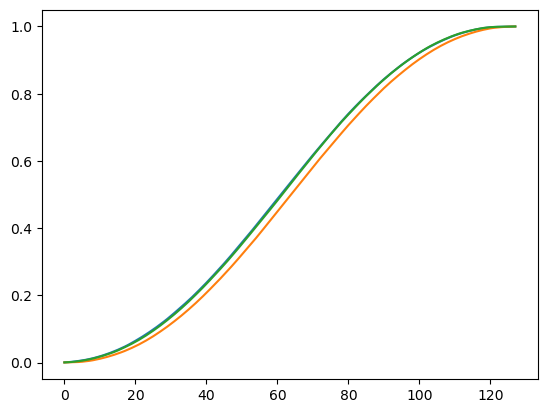

In [18]:
unit=np.pi
ndim=3
maxeval=2000000
exact = 1.3932  # exact value of the integral
    
cum = Cumulants()
    
nbins=128
nstart =100000
nincrease=5000

grid = Grid(ndim,nbins)

np.random.seed(0)

Vegas_step3b(my_integrant2, np.pi, maxeval, nstart, nincrease, grid, cum)

print (cum.avg, '+-', cum.err, 'exact=', exact, 'real error=', abs(cum.avg-exact)/exact)

plt.plot(grid.g[0,:nbins])
plt.plot(grid.g[1,:nbins])
plt.plot(grid.g[2,:nbins])

Vegas parameters:
       ndim = 3
       unit = 3.141592653589793
       maxeval = 2000000
       nstart = 100000
       nincrease = 5000
       nbins = 128
       nbaths = 1000

Iteration   1: I= 10.94098767 +- 0.08186471  chisq= 0.00000000 number of evaluations =  100000 
Iteration   2: I= 11.07948909 +- 0.04416357  chisq= 1.17495384 number of evaluations =  205000 
Iteration   3: I= 11.12856627 +- 0.02925556  chisq= 2.14060141 number of evaluations =  315000 
Iteration   4: I= 11.13762330 +- 0.02284821  chisq= 2.29047054 number of evaluations =  430000 
Iteration   5: I= 11.15135384 +- 0.01975354  chisq= 3.35932903 number of evaluations =  550000 
Iteration   6: I= 11.14619159 +- 0.01735288  chisq= 3.59019132 number of evaluations =  675000 
Iteration   7: I= 11.13899961 +- 0.01527165  chisq= 4.18020183 number of evaluations =  805000 
Iteration   8: I= 11.12676965 +- 0.01368735  chisq= 6.79896357 number of evaluations =  940000 
Iteration   9: I= 11.12992056 +- 0.01274457  chisq= 7

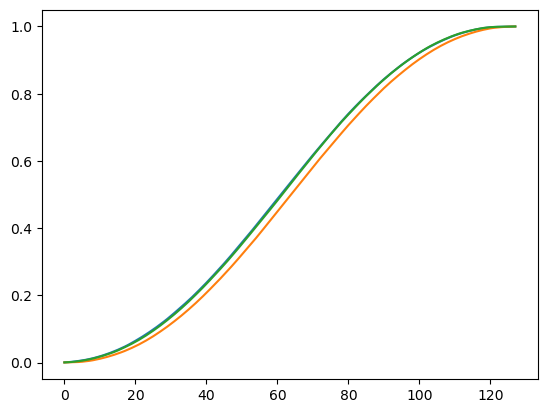

In [19]:
unit=np.pi
ndim=3
maxeval=2000000
    
cum = Cumulants()
    
nbins = 128
nstart = 100000
nincrease=5000

grid = Grid(ndim, nbins)

np.random.seed(0)

Vegas_step4(my_integrant2, [-np.pi, np.pi], maxeval, nstart, nincrease, grid, cum)

print (cum.avg, '+-', cum.err, 'exact=', exact, 'real error=', abs(cum.avg-exact)/exact)

plt.plot(grid.g[0,:nbins])
plt.plot(grid.g[1,:nbins])
plt.plot(grid.g[2,:nbins])

Now, in class, we discussed that when we change the bounds from [-1, 1] to $[-\pi, \pi]$ the value should increase by $2^3$. Is this the case?

In [20]:
1.3928952457852943 * 8

11.143161966282355

Yes, this seems right!

In [21]:
# we defined these functions in class for the integral we seek to evaluate

@njit
def ferm(k):
    if k>700:
        return 0.
    else: 
        return 1./(np.exp(k)+1.)

@njit
def linhard_inside(km, omega, q, res, kf, T, broad, nrm):
    for i in range(km.shape[0]):
        k = km[i,0:3]
        a_k_q = np.linalg.norm(k-q)**2 - kf*kf
        a_k = np.linalg.norm(k)**2 - kf*kf
        dfermi = (ferm(a_k_q/T)-ferm(a_k/T))
        res[i]= -2*nrm*dfermi/(omega-a_k_q+a_k+broad*1j) # broad is idelta
        
    return res

In [22]:
class Linhard:

    def __init__(self, omega, q, kf, f, broad):
        self.omega = omega
        self.q = q
        self.kf = kf
        self.f = f
        self.broad = broad
        self.nrm = 1/(2*np.pi)**3
    
    def __call__(self, k):
        res = np.zeros(k.shape[0], dtype='complex')
        return linhard_inside(k, self.omega, self.q, res, self.kf, self.f, self.broad, self.nrm)

In [23]:
# here im using the parameters from class
rs = 2
kf = pow(9*np.pi/4, 1/3)/rs
lh = Linhard(omega=0, q=0.1*kf, kf=kf, f=0.02*kf**2, broad=0.002*kf**2)

maxeval = 10000000
nstart = 100000
nincrease = 100000

maxeval=1e7
ndim=3
nbins = 128

cum = Cumulants()
grid = Grid(ndim, nbins)

Vegas_step4(lh, [-3*kf, 3*kf], maxeval, nstart, nincrease, grid, cum)
print (cum.avg, '+-', cum.err, 'exact=', exact, 'real error=', abs(cum.avg-exact)/exact)

Vegas parameters:
       ndim = 3
       unit = 3.141592653589793
       maxeval = 10000000.0
       nstart = 100000
       nincrease = 100000
       nbins = 128
       nbaths = 1000

Iteration   1: I= -0.04184514+0.00029054j +- 0.00144009  chisq= 0.00000000 number of evaluations =  100000 
Iteration   2: I= -0.04308078+0.00029964j +- 0.00025522  chisq= 0.02387490 number of evaluations =  300000 
Iteration   3: I= -0.04289367+0.00029806j +- 0.00014774  chisq= 0.29475613 number of evaluations =  600000 
Iteration   4: I= -0.04310070+0.00029939j +- 0.00010528  chisq= 2.32076927 number of evaluations = 1000000 
Iteration   5: I= -0.04308763+0.00029938j +- 0.00007991  chisq= 2.34169581 number of evaluations = 1500000 
Iteration   6: I= -0.04316031+0.00029974j +- 0.00006421  chisq= 3.84864543 number of evaluations = 2100000 
Iteration   7: I= -0.04311580+0.00029946j +- 0.00005436  chisq= 5.06414119 number of evaluations = 2800000 
Iteration   8: I= -0.04310950+0.00029948j +- 0.00004706  chi

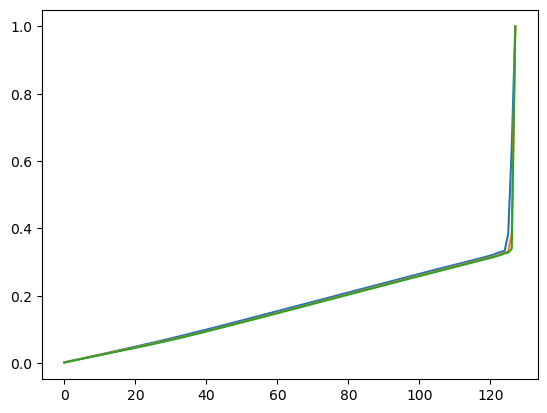

In [24]:
plt.plot(grid.g[0,:nbins])
plt.plot(grid.g[1,:nbins])
plt.plot(grid.g[2,:nbins])